**Import Libraries**

In [23]:
# Standard Libraries
import os
import copy
import random
from glob import glob
from PIL import Image

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score

# BYOL library
from lightly.transforms.byol_transform import BYOLTransform, BYOLView1Transform, BYOLView2Transform
from lightly.models.modules import BYOLProjectionHead, BYOLPredictionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.loss import NegativeCosineSimilarity
from lightly.utils.scheduler import cosine_schedule

**Define Parameters**

In [24]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# Parameters BYOL pre-training
LEARNING_RATE_BYOL = 0.06
EPOCHS_BYOL = 100
BATCH_SIZE_BYOL = 128

# Parameters training
LEARNING_RATE = 0.001
LEARNING_RATE_FINE_TUNING = 0.0001
EPOCHS = 3
EPOCHS_FINE_TUNING = 100
BATCH_SIZE = 32

# Parameters early stopping
EARLY_STOPPING_PATIENCE = 10

# Parameters learning rate scheduler
LEARNING_RATE_SCHEDULER_PATIENCE = 5
LEARNING_RATE_SCHEDULER_MODE = 'min'
LEARNING_RATE_SCHEDULER_FACTOR = 0.1

# Other parameters
SEED = 42
NUM_WORKERS = 32

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [25]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data**

In [26]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Extract ChestX-ray14 dataset
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [27]:
def load_labels(csv_path, extracted_path):
    """
    Read labels from CSV, maps images to paths, and create binary disease labels.
    """

    # Read the CSV containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create binary column for 'No Finding'
    labels_df['No Finding'] = labels_df['Finding Labels'].str.contains('No Finding').astype(int)

    # Map images to their full path
    labels_df['Path'] = labels_df['Image Index'].map(
        {os.path.basename(path): path for path in glob(os.path.join(extracted_path, '**', 'images', '*.png'))}
    )
    
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Split Dataset**

In [28]:
# Split based on patients
unique_patients = df['Patient ID'].unique()

# Split patients into training, validation and test sets
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.125, random_state=SEED
)

# Create dataframes for training, validation, and test sets
train_df = df[df['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = df[df['Patient ID'].isin(val_patients)].reset_index(drop=True)
test_df = df[df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 78614
Validation size: 11212
Test size: 22294


**Define Dataset for Chest X-ray images**

In [29]:
class ChestXrayDataset(Dataset):
    """
    Create dataset for Chest X-ray images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        # Get image and labels
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformation on image
        image = self.transform(image)
        
        return image, label

**Define Data Transformations**

In [30]:
# Define transformations for training data
train_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize(224),

    # Apply random horizontal flip
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image with ±10 degrees
    transforms.RandomRotation(10),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize(224),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Create Datasets**

In [31]:
train_dataset = ChestXrayDataset(train_df, transform=train_transforms)
val_dataset = ChestXrayDataset(val_df, transform=test_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Create DataLoaders**

In [32]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# **Step 3: BYOL Pre-training**

**Define the BYOL transformations**

In [33]:
def get_xray_transform():
    return transforms.Compose([

        # Convert image to PIL format
        transforms.ToPILImage(),

        # Convert to 3 channels
        transforms.Grayscale(num_output_channels=3),

        # Apply random cropping and resize the image to 224x224
        transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),

        # Apply random horizontal flipping
        transforms.RandomHorizontalFlip(p=0.5),

        # Apply random Gaussian blur
        transforms.GaussianBlur(kernel_size=21, sigma=(0.1, 2.0)),

        # Convert the image to a PyTorch tensor
        transforms.ToTensor(),

        # Normalize using ImageNet mean and std
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

byol_transform = BYOLTransform(
    view_1_transform=get_xray_transform(),
    view_2_transform=get_xray_transform()
)

**Define the BYOL model**

In [34]:
class BYOL(nn.Module):
    def __init__(self):
        super().__init__()

        # The online network
        self.backbone = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)  
        self.projection_head = BYOLProjectionHead(1000, 1024, 256)
        self.prediction_head = BYOLPredictionHead(256, 1024, 256)

        # The target network
        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        # Freeze the teacher network. Only update using EMA
        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

    def forward_student(self, x):
        # Forward pass student network
        y = self.backbone(x)
        z = self.projection_head(y)
        p = self.prediction_head(z)
        return p

    def forward_teacher(self, x):
        # Forward pass teacher network
        y = self.backbone_momentum(x)
        z = self.projection_head_momentum(y)
        return z.detach()

# Initalize BYOL model
byol_model = BYOL().to(device)

**Create BYOL Dataset**

In [35]:
class BYOLDataset(torch.utils.data.Dataset):
    """
    Dataset for BYOL.
    Returns two augmented versions of each image.
    """
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)

        # Apply the BYOL transform to generate two augmented views
        view1, view2 = self.transform(image)

        return view1, view2

# Recreate SimCLR Dataset with the updated __getitem__ method
byol_train_dataset = BYOLDataset(train_df, transform=byol_transform)
byol_val_dataset = BYOLDataset(val_df, transform=byol_transform)

**Initialize BYOL DataLoader**

In [36]:
byol_train_loader = DataLoader(
    byol_train_dataset,
    batch_size=BATCH_SIZE_BYOL,
    shuffle=True,
    num_workers=NUM_WORKERS,
    drop_last=True
)

byol_val_loader = DataLoader(
    byol_val_dataset,
    batch_size=BATCH_SIZE_BYOL,
    shuffle=False,
    num_workers=NUM_WORKERS,
    drop_last=False
)

**Initialize Optimizer and Loss for BYOL**

In [37]:
criterion = NegativeCosineSimilarity()
optimizer_byol = torch.optim.SGD(byol_model.parameters(), lr=LEARNING_RATE_BYOL)

**Train BYOL Model**

In [38]:
def train_model(byol_model, byol_train_loader, byol_val_loader, criterion, optimizer, patience, epochs=10):

    # List to store byol loss
    byol_train_losses = []
    byol_val_losses = []

    # Early stopping parameters
    best_loss = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        train_loss = 0.0
        progress_bar = tqdm(byol_train_loader, desc=f"BYOL Epoch {epoch+1}/{epochs}")
        momentum_val = cosine_schedule(epoch, epochs, 0.996, 1)

        for batch in progress_bar:
            x0, x1 = batch
            update_momentum(byol_model.backbone, byol_model.backbone_momentum, m=momentum_val)
            update_momentum(byol_model.projection_head, byol_model.projection_head_momentum, m=momentum_val)

            x0 = x0.to(device)
            x1 = x1.to(device)

            # Forward pass
            p0 = byol_model.forward_student(x0)
            z0 = byol_model.forward_teacher(x0)
            p1 = byol_model.forward_student(x1)
            z1 = byol_model.forward_teacher(x1)

            # Compute loss
            loss = 0.5 * (criterion(p0, z1) + criterion(p1, z0))

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item()
            progress_bar.set_postfix({"Loss": loss.item()})

        train_loss = train_loss / len(byol_train_loader)
        byol_train_losses.append(train_loss)

        # Validation loop
        byol_model.eval()
        val_loss = 0
        progress_bar = tqdm(byol_val_loader, desc=f"BYOL Epoch {epoch+1}/{epochs}")
        with torch.no_grad():
            for batch in progress_bar:
                x0, x1 = batch

                x0 = x0.to(device)
                x1 = x1.to(device)

                # Forward pass
                p0 = byol_model.forward_student(x0)
                z0 = byol_model.forward_teacher(x0)
                p1 = byol_model.forward_student(x1)
                z1 = byol_model.forward_teacher(x1)

                # Compute loss
                loss = 0.5 * (criterion(p0, z1) + criterion(p1, z0))
                val_loss  += loss.item()
                progress_bar.set_postfix({"Loss": loss.item()})

        val_loss = val_loss / len(byol_val_loader)
        byol_val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f}")

        # Early stopping
        if best_loss > val_loss:
            best_loss = val_loss
            epochs_without_improvement = 0
            torch.save(byol_model.state_dict(), 'best_model_2.pt')
            print(f"New best model saved with Loss: {val_loss:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience :
                print(f"Early stopping. No improvement for {patience } epochs")
                break

    # Load the best model
    byol_model.load_state_dict(torch.load('best_model_2.pt', weights_only=True))

    return byol_train_losses, byol_val_losses

# Train the model for the desired number of epochs
byol_train_losses, byol_val_losses = train_model(byol_model, byol_train_loader, byol_val_loader, criterion, optimizer_byol, EARLY_STOPPING_PATIENCE, EPOCHS_BYOL)

BYOL Epoch 1/100:   0%|          | 0/614 [00:00<?, ?it/s]

BYOL Epoch 1/100: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s, Loss=-0.875]


Epoch 1/100 | Training Loss: -0.7060 | Validation Loss: -0.8763
New best model saved with Loss: -0.8763


BYOL Epoch 2/100: 100%|██████████| 88/88 [00:28<00:00,  3.06it/s, Loss=-0.966]


Epoch 2/100 | Training Loss: -0.8760 | Validation Loss: -0.9462
New best model saved with Loss: -0.9462


BYOL Epoch 3/100: 100%|██████████| 88/88 [00:28<00:00,  3.05it/s, Loss=-0.978]


Epoch 3/100 | Training Loss: -0.9635 | Validation Loss: -0.9719
New best model saved with Loss: -0.9719


BYOL Epoch 4/100: 100%|██████████| 88/88 [00:28<00:00,  3.04it/s, Loss=-0.979]


Epoch 4/100 | Training Loss: -0.9728 | Validation Loss: -0.9770
New best model saved with Loss: -0.9770


BYOL Epoch 5/100: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s, Loss=-0.981]


Epoch 5/100 | Training Loss: -0.9770 | Validation Loss: -0.9799
New best model saved with Loss: -0.9799


BYOL Epoch 6/100: 100%|██████████| 88/88 [00:28<00:00,  3.04it/s, Loss=-0.982]


Epoch 6/100 | Training Loss: -0.9775 | Validation Loss: -0.9760


BYOL Epoch 7/100: 100%|██████████| 88/88 [00:28<00:00,  3.05it/s, Loss=-0.98] 


Epoch 7/100 | Training Loss: -0.9774 | Validation Loss: -0.9771


BYOL Epoch 8/100: 100%|██████████| 88/88 [00:28<00:00,  3.04it/s, Loss=-0.979]


Epoch 8/100 | Training Loss: -0.9774 | Validation Loss: -0.9793


BYOL Epoch 9/100: 100%|██████████| 88/88 [00:29<00:00,  3.01it/s, Loss=-0.984]


Epoch 9/100 | Training Loss: -0.9779 | Validation Loss: -0.9798


BYOL Epoch 10/100: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s, Loss=-0.976]


Epoch 10/100 | Training Loss: -0.9779 | Validation Loss: -0.9781


BYOL Epoch 11/100: 100%|██████████| 88/88 [00:29<00:00,  3.02it/s, Loss=-0.981]


Epoch 11/100 | Training Loss: -0.9780 | Validation Loss: -0.9798


BYOL Epoch 12/100: 100%|██████████| 88/88 [00:29<00:00,  3.02it/s, Loss=-0.981]


Epoch 12/100 | Training Loss: -0.9781 | Validation Loss: -0.9806
New best model saved with Loss: -0.9806


BYOL Epoch 13/100: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s, Loss=-0.977]


Epoch 13/100 | Training Loss: -0.9789 | Validation Loss: -0.9779


BYOL Epoch 14/100: 100%|██████████| 88/88 [00:30<00:00,  2.84it/s, Loss=-0.981]


Epoch 14/100 | Training Loss: -0.9796 | Validation Loss: -0.9802


BYOL Epoch 15/100: 100%|██████████| 88/88 [00:29<00:00,  3.01it/s, Loss=-0.978]


Epoch 15/100 | Training Loss: -0.9807 | Validation Loss: -0.9807
New best model saved with Loss: -0.9807


BYOL Epoch 16/100: 100%|██████████| 88/88 [00:28<00:00,  3.04it/s, Loss=-0.984]


Epoch 16/100 | Training Loss: -0.9817 | Validation Loss: -0.9833
New best model saved with Loss: -0.9833


BYOL Epoch 17/100: 100%|██████████| 88/88 [00:28<00:00,  3.05it/s, Loss=-0.981]


Epoch 17/100 | Training Loss: -0.9823 | Validation Loss: -0.9834
New best model saved with Loss: -0.9834


BYOL Epoch 18/100: 100%|██████████| 88/88 [00:28<00:00,  3.05it/s, Loss=-0.981]


Epoch 18/100 | Training Loss: -0.9829 | Validation Loss: -0.9834
New best model saved with Loss: -0.9834


BYOL Epoch 19/100: 100%|██████████| 88/88 [00:28<00:00,  3.05it/s, Loss=-0.981]


Epoch 19/100 | Training Loss: -0.9829 | Validation Loss: -0.9834
New best model saved with Loss: -0.9834


BYOL Epoch 20/100: 100%|██████████| 88/88 [00:28<00:00,  3.04it/s, Loss=-0.982]


Epoch 20/100 | Training Loss: -0.9836 | Validation Loss: -0.9840
New best model saved with Loss: -0.9840


BYOL Epoch 21/100: 100%|██████████| 88/88 [00:29<00:00,  3.00it/s, Loss=-0.977]


Epoch 21/100 | Training Loss: -0.9839 | Validation Loss: -0.9836


BYOL Epoch 22/100: 100%|██████████| 88/88 [00:31<00:00,  2.84it/s, Loss=-0.98] 


Epoch 22/100 | Training Loss: -0.9843 | Validation Loss: -0.9850
New best model saved with Loss: -0.9850


BYOL Epoch 23/100: 100%|██████████| 88/88 [00:28<00:00,  3.05it/s, Loss=-0.98] 


Epoch 23/100 | Training Loss: -0.9848 | Validation Loss: -0.9858
New best model saved with Loss: -0.9858


BYOL Epoch 24/100: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s, Loss=-0.966]


Epoch 24/100 | Training Loss: -0.9851 | Validation Loss: -0.9790


BYOL Epoch 25/100: 100%|██████████| 88/88 [00:28<00:00,  3.06it/s, Loss=-0.986]


Epoch 25/100 | Training Loss: -0.9857 | Validation Loss: -0.9867
New best model saved with Loss: -0.9867


BYOL Epoch 26/100: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s, Loss=-0.985]


Epoch 26/100 | Training Loss: -0.9861 | Validation Loss: -0.9871
New best model saved with Loss: -0.9871


BYOL Epoch 27/100: 100%|██████████| 88/88 [00:28<00:00,  3.04it/s, Loss=-0.986]


Epoch 27/100 | Training Loss: -0.9865 | Validation Loss: -0.9871


BYOL Epoch 28/100: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s, Loss=-0.985]


Epoch 28/100 | Training Loss: -0.9867 | Validation Loss: -0.9873
New best model saved with Loss: -0.9873


BYOL Epoch 29/100: 100%|██████████| 88/88 [00:28<00:00,  3.04it/s, Loss=-0.982]


Epoch 29/100 | Training Loss: -0.9867 | Validation Loss: -0.9862


BYOL Epoch 30/100: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s, Loss=-0.986]


Epoch 30/100 | Training Loss: -0.9867 | Validation Loss: -0.9873


BYOL Epoch 31/100: 100%|██████████| 88/88 [00:29<00:00,  3.01it/s, Loss=-0.987]


Epoch 31/100 | Training Loss: -0.9870 | Validation Loss: -0.9885
New best model saved with Loss: -0.9885


BYOL Epoch 32/100: 100%|██████████| 88/88 [00:28<00:00,  3.04it/s, Loss=-0.988]


Epoch 32/100 | Training Loss: -0.9877 | Validation Loss: -0.9887
New best model saved with Loss: -0.9887


BYOL Epoch 33/100: 100%|██████████| 88/88 [00:28<00:00,  3.04it/s, Loss=-0.99] 


Epoch 33/100 | Training Loss: -0.9886 | Validation Loss: -0.9894
New best model saved with Loss: -0.9894


BYOL Epoch 34/100: 100%|██████████| 88/88 [00:29<00:00,  3.01it/s, Loss=-0.986]


Epoch 34/100 | Training Loss: -0.9890 | Validation Loss: -0.9894
New best model saved with Loss: -0.9894


BYOL Epoch 35/100: 100%|██████████| 88/88 [00:29<00:00,  3.01it/s, Loss=-0.986]


Epoch 35/100 | Training Loss: -0.9895 | Validation Loss: -0.9901
New best model saved with Loss: -0.9901


BYOL Epoch 36/100: 100%|██████████| 88/88 [00:28<00:00,  3.04it/s, Loss=-0.987]


Epoch 36/100 | Training Loss: -0.9898 | Validation Loss: -0.9901
New best model saved with Loss: -0.9901


BYOL Epoch 37/100: 100%|██████████| 88/88 [00:28<00:00,  3.04it/s, Loss=-0.984]


Epoch 37/100 | Training Loss: -0.9898 | Validation Loss: -0.9901


BYOL Epoch 38/100: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s, Loss=-0.986]


Epoch 38/100 | Training Loss: -0.9898 | Validation Loss: -0.9905
New best model saved with Loss: -0.9905


BYOL Epoch 39/100: 100%|██████████| 88/88 [00:28<00:00,  3.05it/s, Loss=-0.986]


Epoch 39/100 | Training Loss: -0.9897 | Validation Loss: -0.9900


BYOL Epoch 40/100: 100%|██████████| 88/88 [00:29<00:00,  3.00it/s, Loss=-0.99] 


Epoch 40/100 | Training Loss: -0.9897 | Validation Loss: -0.9902


BYOL Epoch 41/100: 100%|██████████| 88/88 [00:28<00:00,  3.05it/s, Loss=-0.992]


Epoch 41/100 | Training Loss: -0.9897 | Validation Loss: -0.9900


BYOL Epoch 42/100: 100%|██████████| 88/88 [00:28<00:00,  3.04it/s, Loss=-0.986]


Epoch 42/100 | Training Loss: -0.9896 | Validation Loss: -0.9903


BYOL Epoch 43/100: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s, Loss=-0.985]


Epoch 43/100 | Training Loss: -0.9895 | Validation Loss: -0.9902


BYOL Epoch 44/100: 100%|██████████| 88/88 [00:29<00:00,  3.01it/s, Loss=-0.986]


Epoch 44/100 | Training Loss: -0.9896 | Validation Loss: -0.9885


BYOL Epoch 45/100: 100%|██████████| 88/88 [00:28<00:00,  3.04it/s, Loss=-0.986]


Epoch 45/100 | Training Loss: -0.9894 | Validation Loss: -0.9901


BYOL Epoch 46/100: 100%|██████████| 88/88 [00:29<00:00,  2.98it/s, Loss=-0.99] 


Epoch 46/100 | Training Loss: -0.9893 | Validation Loss: -0.9899


BYOL Epoch 47/100: 100%|██████████| 88/88 [00:28<00:00,  3.04it/s, Loss=-0.985]


Epoch 47/100 | Training Loss: -0.9893 | Validation Loss: -0.9900


BYOL Epoch 48/100: 100%|██████████| 88/88 [00:29<00:00,  3.02it/s, Loss=-0.986]


Epoch 48/100 | Training Loss: -0.9893 | Validation Loss: -0.9883
Early stopping. No improvement for 10 epochs


# **Step 4: Build the Model**

**Initialize the Multi-Label Classifier Model**

In [39]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using Swin Transformer as the base model.
    """
    def __init__(self, backbone, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained Swin Transformer model
        self.base_model = backbone.backbone

        # Replace the classification head to match the number of disease labels
        self.base_model.classifier = nn.Linear(self.base_model.classifier.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Initialize the Model
model = MultiLabelClassifier(byol_model)
model.to(device)

MultiLabelClassifier(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-

**Use Multiple GPUs**

In [40]:
model = nn.DataParallel(model)

# **Step 5: Train the Model**

**Step 1: Train Classification Head Only**

In [41]:
# Freeze the backbone parameters
for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False

In [42]:
# Initialize loss function
criterion = nn.BCEWithLogitsLoss()

# Initialize optimizer
optimizer_head = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

# Initialize scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_head, factor=LEARNING_RATE_SCHEDULER_FACTOR, patience=LEARNING_RATE_SCHEDULER_PATIENCE, mode=LEARNING_RATE_SCHEDULER_MODE)

In [43]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    # Early stopping parameters
    best_score = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

        # Early stopping
        if mean_auc > best_score:
            best_score = mean_auc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model_2.pt')
            print(f"New best model saved with Mean Validation AUC: {mean_auc:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping. No improvement for {patience} epochs")
                break
                
    # Load the best model
    model.load_state_dict(torch.load('best_model_2.pt', weights_only=True))

    return train_losses, val_losses, val_aucs

# Train the model
train_losses_1, val_losses_1, val_aucs_1 = train_model(model, train_loader, val_loader, criterion, optimizer_head, EARLY_STOPPING_PATIENCE, EPOCHS)

Epoch 1/3: 100%|██████████| 351/351 [00:11<00:00, 31.79it/s, Loss=0.163] 


Epoch 1/3 | Training Loss: 0.1738 | Validation Loss: 0.1678 | Mean Validation AUC: 0.7315
New best model saved with Mean Validation AUC: 0.7315


Epoch 2/3: 100%|██████████| 351/351 [00:11<00:00, 31.82it/s, Loss=0.16]  


Epoch 2/3 | Training Loss: 0.1694 | Validation Loss: 0.1671 | Mean Validation AUC: 0.7436
New best model saved with Mean Validation AUC: 0.7436


Epoch 3/3: 100%|██████████| 351/351 [00:10<00:00, 32.28it/s, Loss=0.13]  


Epoch 3/3 | Training Loss: 0.1687 | Validation Loss: 0.1665 | Mean Validation AUC: 0.7464
New best model saved with Mean Validation AUC: 0.7464


**Step 2: Fine Tune Entire Network**

In [44]:
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

In [45]:
# Initialize optimizer
optimizer_full = optim.Adam(model.parameters(), lr=LEARNING_RATE_FINE_TUNING)

# Initialize scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_full, factor=LEARNING_RATE_SCHEDULER_FACTOR, patience=LEARNING_RATE_SCHEDULER_PATIENCE, mode=LEARNING_RATE_SCHEDULER_MODE)

In [46]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    # Early stopping parameters
    best_score = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

        # Early stopping
        if mean_auc > best_score:
            best_score = mean_auc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model_2.pt')
            print(f"New best model saved with Mean Validation AUC: {mean_auc:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping. No improvement for {patience:.4f} epochs")
                break

    # Load the best model
    model.load_state_dict(torch.load('best_model_2.pt', weights_only=True))

    return train_losses, val_losses, val_aucs

# Train the model for the desired number of epochs
train_losses_2, val_losses_2, val_aucs_2 = train_model(model, train_loader, val_loader, criterion, optimizer_full, EARLY_STOPPING_PATIENCE, EPOCHS_FINE_TUNING)

Epoch 1/100: 100%|██████████| 351/351 [00:11<00:00, 31.74it/s, Loss=0.108] 


Epoch 1/100 | Training Loss: 0.1575 | Validation Loss: 0.1507 | Mean Validation AUC: 0.8123
New best model saved with Mean Validation AUC: 0.8123


Epoch 2/100: 100%|██████████| 351/351 [00:10<00:00, 32.10it/s, Loss=0.108] 


Epoch 2/100 | Training Loss: 0.1492 | Validation Loss: 0.1470 | Mean Validation AUC: 0.8281
New best model saved with Mean Validation AUC: 0.8281


Epoch 3/100: 100%|██████████| 351/351 [00:11<00:00, 31.51it/s, Loss=0.117] 


Epoch 3/100 | Training Loss: 0.1455 | Validation Loss: 0.1473 | Mean Validation AUC: 0.8307
New best model saved with Mean Validation AUC: 0.8307


Epoch 4/100: 100%|██████████| 351/351 [00:11<00:00, 31.56it/s, Loss=0.128] 


Epoch 4/100 | Training Loss: 0.1424 | Validation Loss: 0.1448 | Mean Validation AUC: 0.8378
New best model saved with Mean Validation AUC: 0.8378


Epoch 5/100: 100%|██████████| 351/351 [00:11<00:00, 31.78it/s, Loss=0.122] 


Epoch 5/100 | Training Loss: 0.1396 | Validation Loss: 0.1447 | Mean Validation AUC: 0.8361


Epoch 6/100: 100%|██████████| 351/351 [00:11<00:00, 31.88it/s, Loss=0.119] 


Epoch 6/100 | Training Loss: 0.1366 | Validation Loss: 0.1456 | Mean Validation AUC: 0.8334


Epoch 7/100: 100%|██████████| 351/351 [00:11<00:00, 31.78it/s, Loss=0.111] 


Epoch 7/100 | Training Loss: 0.1336 | Validation Loss: 0.1469 | Mean Validation AUC: 0.8323


Epoch 8/100: 100%|██████████| 351/351 [00:11<00:00, 31.70it/s, Loss=0.111] 


Epoch 8/100 | Training Loss: 0.1299 | Validation Loss: 0.1495 | Mean Validation AUC: 0.8270


Epoch 9/100: 100%|██████████| 351/351 [00:11<00:00, 31.64it/s, Loss=0.112] 


Epoch 9/100 | Training Loss: 0.1260 | Validation Loss: 0.1491 | Mean Validation AUC: 0.8291


Epoch 10/100: 100%|██████████| 351/351 [00:11<00:00, 31.66it/s, Loss=0.112] 


Epoch 10/100 | Training Loss: 0.1219 | Validation Loss: 0.1525 | Mean Validation AUC: 0.8306


Epoch 11/100: 100%|██████████| 351/351 [00:11<00:00, 31.61it/s, Loss=0.114] 


Epoch 11/100 | Training Loss: 0.1172 | Validation Loss: 0.1552 | Mean Validation AUC: 0.8175


Epoch 12/100: 100%|██████████| 351/351 [00:11<00:00, 31.41it/s, Loss=0.142] 


Epoch 12/100 | Training Loss: 0.1123 | Validation Loss: 0.1624 | Mean Validation AUC: 0.8187


Epoch 13/100: 100%|██████████| 351/351 [00:11<00:00, 31.69it/s, Loss=0.12]  


Epoch 13/100 | Training Loss: 0.1073 | Validation Loss: 0.1652 | Mean Validation AUC: 0.8111


Epoch 14/100: 100%|██████████| 351/351 [00:11<00:00, 31.42it/s, Loss=0.13]  


Epoch 14/100 | Training Loss: 0.1016 | Validation Loss: 0.1673 | Mean Validation AUC: 0.8082
Early stopping. No improvement for 10.0000 epochs


# **Step 6: Evaluate the Model**

**Test-time Augmentations**

In [47]:
tta_transforms = [
    lambda img: img,
    lambda img: transforms.RandomHorizontalFlip(p=1.0)(img),
    lambda img: transforms.RandomRotation(10)(img)
]

**Evaluate the Model**

In [48]:
def evaluate_model(model, test_loader):
    """
    Evaluates the model on the test set and returns predictions and true labels.
    """
    model.eval()
    all_preds = []
    all_labels = []

    # Progress bar
    progress_bar = tqdm(test_loader, desc="Evaluating on Test Set")

    # Disable gradients for evaluation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)

            tta_preds = []
            
            # Apply each TTA transformation and predict
            for tta in tta_transforms:
                augmented_inputs = tta(inputs)
                outputs = model(augmented_inputs)
                preds = torch.sigmoid(outputs)
                tta_preds.append(preds)

            # Average the predictions across TTA transforms
            avg_preds = torch.stack(tta_preds).mean(dim=0).cpu()

            # Store predictions and true labels
            all_preds.append(avg_preds)
            all_labels.append(labels)

    # Concatenate all batches
    preds = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    return preds, labels

# Get predictions and true labels
preds, labels = evaluate_model(model, test_loader)

Evaluating on Test Set:   0%|          | 0/697 [00:00<?, ?it/s]

Evaluating on Test Set: 100%|██████████| 697/697 [00:41<00:00, 16.60it/s]


**Compute Metrics for Each Label**

In [49]:
# Initialize dictionaries for metrics
accuracy_per_label = {}
f1_per_label = {}
roc_auc_per_label = {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):
    
    # Binarize predictions with threshold 0.5
    binary_preds = preds[:, i] > 0.5

    # Calculate accuracy
    acc = accuracy_score(labels[:, i], binary_preds)

    # Calculate f1 score
    f1 = f1_score(labels[:, i], binary_preds, average='macro')

    # Calculate ROC AUC
    roc_auc = roc_auc_score(labels[:, i], preds[:, i])

    # Store metrics
    accuracy_per_label[label] = acc
    f1_per_label[label] = f1
    roc_auc_per_label[label] = roc_auc

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'F1 Score': f1_per_label,
    'ROC AUC': roc_auc_per_label
})

# Calculate the mean for all diseases
metrics_df.loc['Overall'] = metrics_df.mean()

# Print dataframe with metrics
metrics_df

,Accuracy,F1 Score,ROC AUC
Atelectasis,0.903382,0.565754,0.806934
Consolidation,0.957343,0.489103,0.813175
Infiltration,0.814614,0.502240,0.706282
Pneumothorax,0.954024,0.498736,0.875321
Edema,0.979187,0.507346,0.891335
Emphysema,0.976137,0.649370,0.918260
Fibrosis,0.983673,0.495885,0.808356
Effusion,0.899255,0.699677,0.881276
Pneumonia,0.986813,0.496681,0.749013
Pleural_Thickening,0.970396,0.492488,0.798838


**Plot ROC curves for each label**

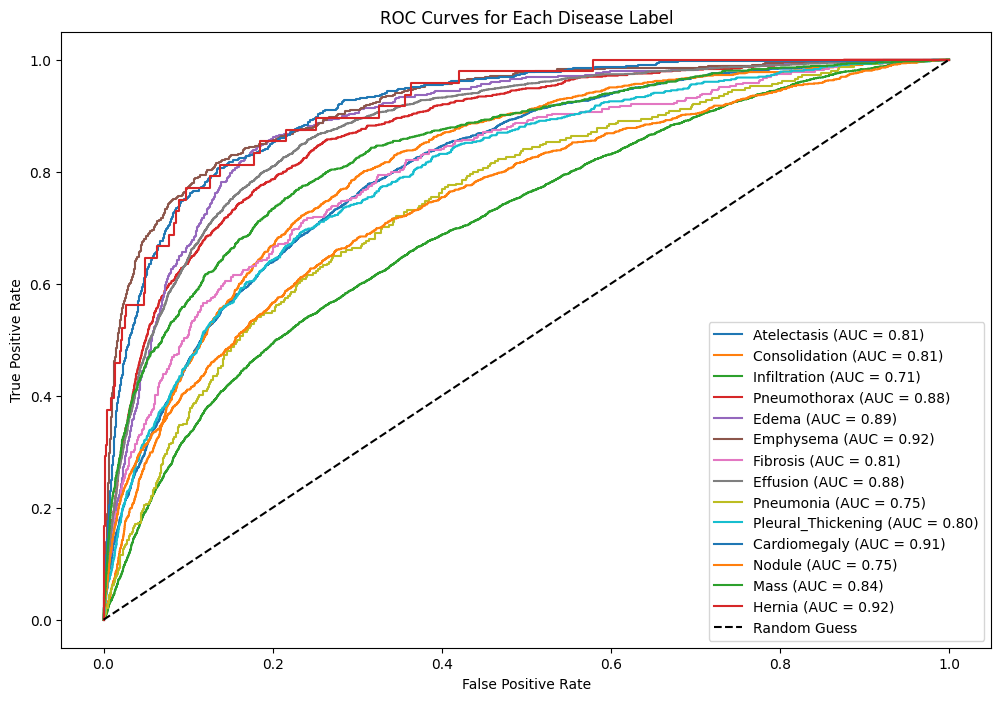

In [50]:
# Plot ROC curves
plt.figure(figsize=(12, 8))
for i, label in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(labels[:, i], preds[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_per_label[label]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Disease Label')
plt.legend(loc='lower right')
plt.show()

**Plot Training and Validation Loss**

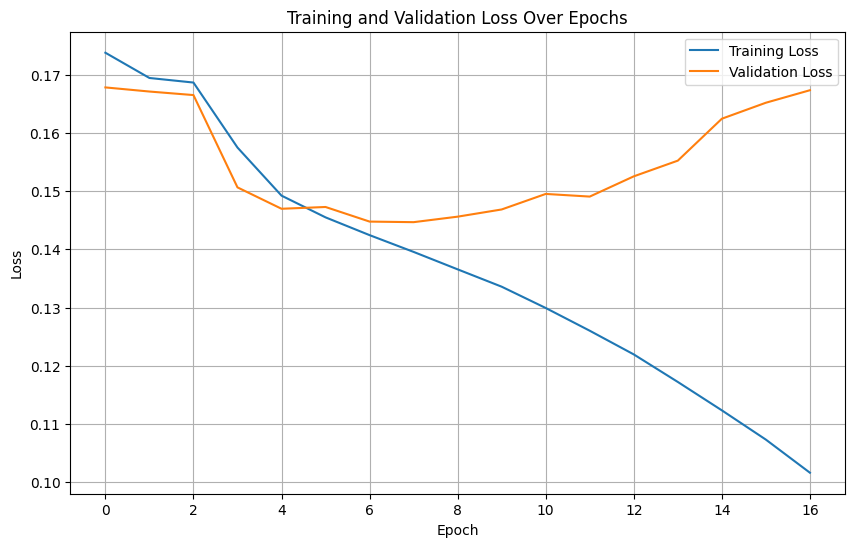

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_1 + train_losses_2, label='Training Loss')
plt.plot(val_losses_1 + val_losses_2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Training and Validation Loss only Fine-tuning**

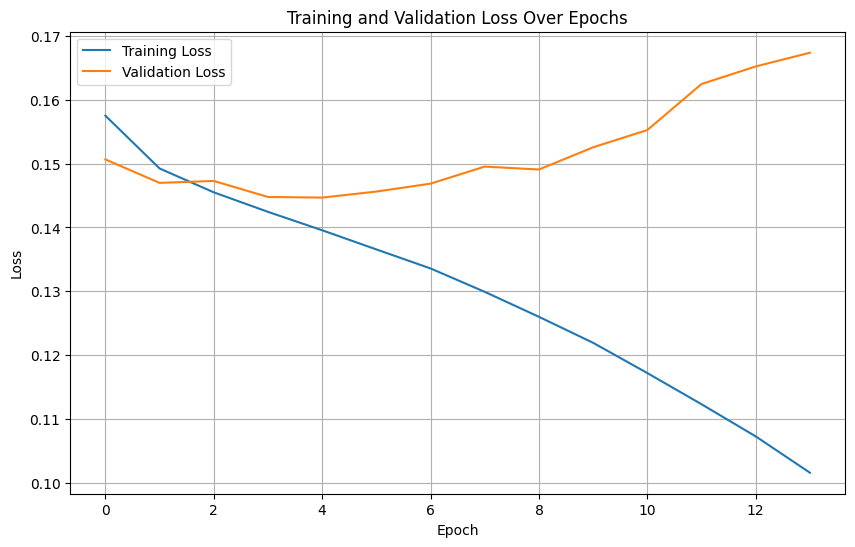

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_2, label='Training Loss')
plt.plot(val_losses_2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC**

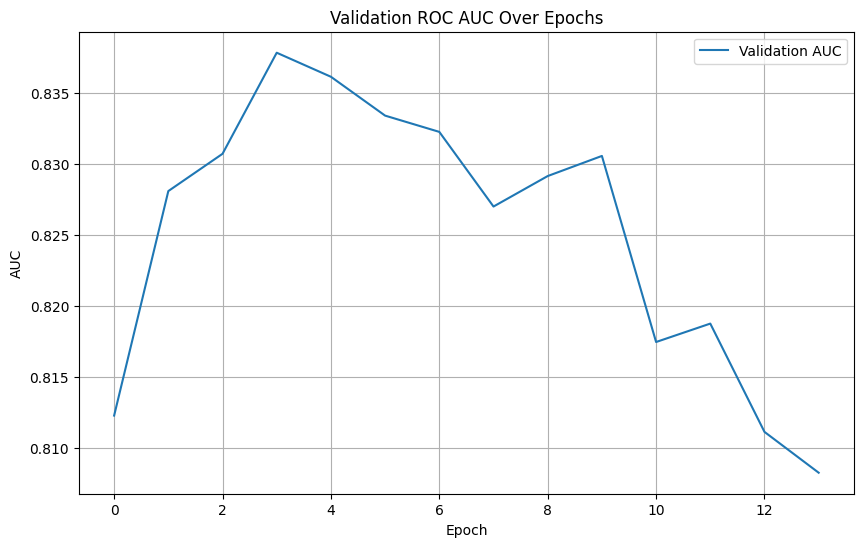

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs_2, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC only Fine-tuning**

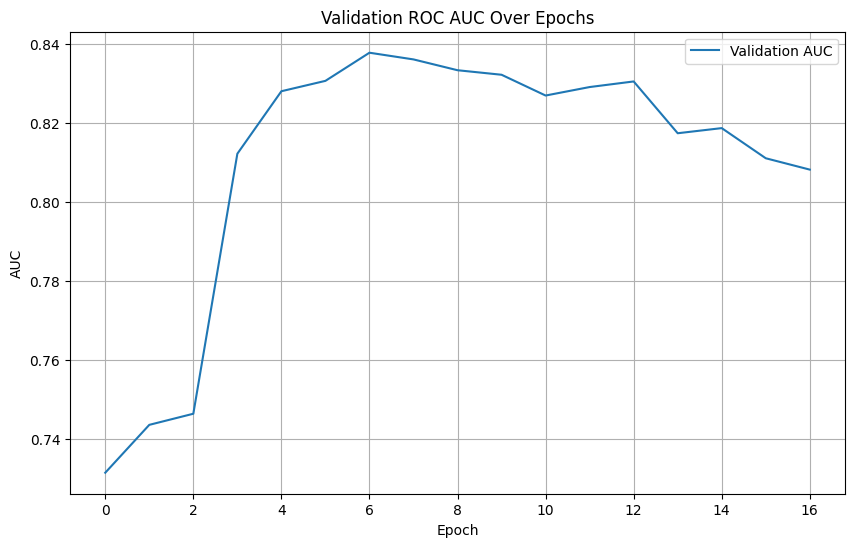

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs_1 + val_aucs_2, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot BYOL Loss**

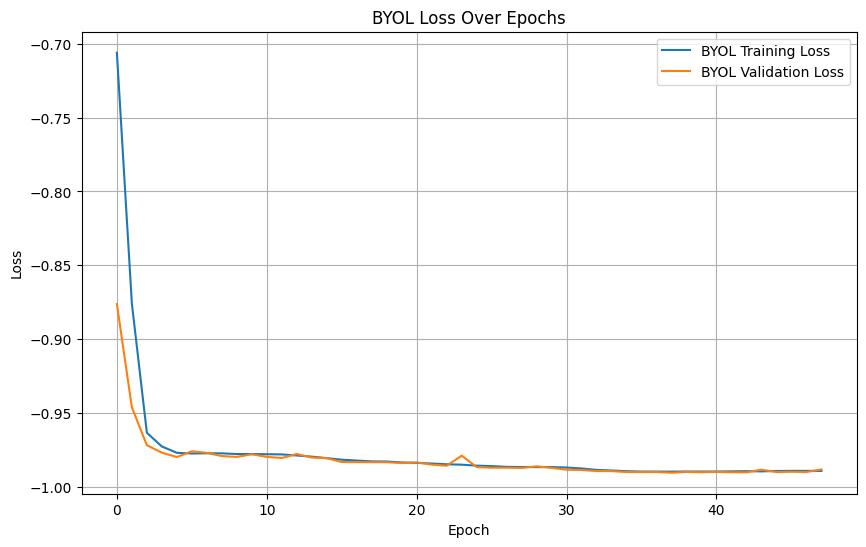

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(byol_train_losses, label='BYOL Training Loss')
plt.plot(byol_val_losses, label='BYOL Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BYOL Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()